In [7]:
from fermion_utils import *
# import flax.linen as nn
# from flax.core import FrozenDict
# from flax import traverse_util
import netket as nk
import netket.experimental as nkx
import netket.nn as nknn

from math import pi

from netket.experimental.operator.fermion import destroy as c
from netket.experimental.operator.fermion import create as cdag
from netket.experimental.operator.fermion import number as nc

In [8]:
# Define the lattice shape
L = 4  # Side of the square
Lx = int(L)
Ly = int(L/2)
# graph = nk.graph.Square(L)
graph = nk.graph.Grid([Lx,Ly], pbc=False)
N = graph.n_nodes


# Define the fermion filling and the Hilbert space
N_f = int(Lx*Ly/2-1)
hi = nkx.hilbert.SpinOrbitalFermions(N, s=None, n_fermions=N_f)


# Define the Hubbard Hamiltonian
t = 1.0
V = 4.0
H = 0.0
for (i, j) in graph.edges(): # Definition of the Hubbard Hamiltonian
    H -= t * (cdag(hi,i) * c(hi,j) + cdag(hi,j) * c(hi,i))
    H += V * nc(hi,i) * nc(hi,j)


# Exact diagonalization of the Hamiltonian for benchmark
sp_h = H.to_sparse() # Convert the Hamiltonian to a sparse matrix
from scipy.sparse.linalg import eigsh
eig_vals, eig_vecs = eigsh(sp_h, k=2, which="SA")
E_gs = eig_vals[0]
print("Exact ground state energy per site:", E_gs/N)

Exact ground state energy per site: -0.39863830653922744


In [9]:
# SU in quimb
Lx = int(L)
Ly = int(L/2)
D = 6
seed = 2
symmetry = 'U1'
peps, parity_config = generate_random_fpeps(Lx, Ly, D, seed, symmetry, Nf=N_f)

edges = qtn.edges_2d_square(Lx, Ly)
site_info = sr.utils.parse_edges_to_site_info(
    edges,
    D,
    phys_dim=2,
    site_ind_id="k{},{}",
    site_tag_id="I{},{}",
)

t = 1.0
V = 4.0
mu = 0.0

terms = {
    (sitea, siteb): sr.fermi_hubbard_spinless_local_array(
        t=t, V=V, mu=mu,
        symmetry=symmetry,
        coordinations=(
            site_info[sitea]['coordination'],
            site_info[siteb]['coordination'],
        ),
    ).fuse((0, 1), (2, 3))
    for (sitea, siteb) in peps.gen_bond_coos()
}
ham = qtn.LocalHam2D(Lx, Ly, terms)
su = qtn.SimpleUpdateGen(peps, ham, compute_energy_per_site=True,D=D, compute_energy_opts={"max_distance":2}, gate_opts={'cutoff':1e-12})

# cluster energies may not be accuracte yet
su.evolve(50, tau=0.3)
su.evolve(50, tau=0.1)
# su.evolve(100, tau=0.03)
# su.evolve(100, tau=0.01)
# su.evolve(100, tau=0.003)

peps = su.get_state()
peps.equalize_norms_(value=1)


n=100, tau=0.1000, energy~-0.399986: 100%|##########| 50/50 [00:01<00:00, 29.56it/s]


fPEPS(tensors=8, indices=18, Lx=4, Ly=2, max_bond=6)

# Energy check

In [10]:
def to_array_check(peps):
    all_config = hi.all_states()
    psi = np.asarray([peps.get_amp(config, conj=True).contract() for config in all_config])
    # print(psi)
    psi = psi/do('linalg.norm', psi)
    return psi

def compute_energy_check(model, hamiltonian):
    psi_gs = to_array_check(model)
    return psi_gs.conj().T@(hamiltonian@psi_gs)/N

hamiltonian = H

compute_energy_check(peps, hamiltonian)


-0.390940200914433

In [11]:
import torch
import torch.nn as nn

# psi.apply_to_arrays(lambda x: torch.tensor(x, dtype=torch.float32))
# ham.apply_to_arrays(lambda x: torch.tensor(x, dtype=torch.float32))
ham = qtn.LocalHam2D(Lx, Ly, terms)
def convert_to_torch(blk_arr):
    new_blks = { sector: torch.tensor(blk, dtype=torch.float32) for sector, blk in blk_arr.blocks.items() }
    new_blk_arr = blk_arr.copy_with(blocks=new_blks)
    return new_blk_arr

ham.apply_to_arrays(lambda x: convert_to_torch(x))
peps.apply_to_arrays(lambda x: torch.tensor(x, dtype=torch.float32))

In [12]:
def product_bra_state(config, peps, symmetry='Z2'):
    """Spinless fermion product bra state."""
    product_tn = qtn.TensorNetwork()
    backend = peps.tensors[0].data.backend
    iterable_oddpos = iter(range(2*peps.nsites+1))
    for n, site in zip(config, peps.sites):
        p_ind = peps.site_ind_id.format(*site)
        p_tag = peps.site_tag_id.format(*site)
        tid = peps.sites.index(site)
        nsites = peps.nsites
        # use autoray to ensure the correct backend is used
        with ar.backend_like(backend):
            if symmetry == 'Z2':
                data = [sr.Z2FermionicArray.from_blocks(blocks={(0,):do('array', [1.0,], like=backend)}, duals=(True,),symmetry='Z2', charge=0, oddpos=2*tid+1), # It doesn't matter if oddpos is None for even parity tensor.
                        sr.Z2FermionicArray.from_blocks(blocks={(1,):do('array', [1.0,], like=backend)}, duals=(True,),symmetry='Z2',charge=1, oddpos=2*tid+1)
                    ]
            elif symmetry == 'U1':
                data = [sr.U1FermionicArray.from_blocks(blocks={(0,):do('array', [1.0,], like=backend)}, duals=(True,),symmetry='U1', charge=0, oddpos=2*tid+1),
                        sr.U1FermionicArray.from_blocks(blocks={(1,):do('array', [1.0,], like=backend)}, duals=(True,),symmetry='U1', charge=1, oddpos=2*tid+1)
                    ]
        tsr_data = data[int(n)] # BUG: does not fit in jax compilation, a concrete value is needed for traced arrays
        tsr = qtn.Tensor(data=tsr_data, inds=(p_ind,),tags=(p_tag, 'bra'))
        product_tn |= tsr
    return product_tn

def get_amp(peps, config, inplace=False, symmetry='Z2', conj=False):
    """Get the amplitude of a configuration in a PEPS."""
    if not inplace:
        peps = peps.copy()
    if conj:
        amp = peps|product_bra_state(config, peps, symmetry).conj()
    else:
        amp = peps|product_bra_state(config, peps, symmetry)
    for site in peps.sites:
        site_tag = peps.site_tag_id.format(*site)
        amp.contract_(tags=site_tag)

    amp.view_as_(
        qtn.PEPS,
        site_ind_id="k{},{}",
        site_tag_id="I{},{}",
        x_tag_id="X{}",
        y_tag_id="Y{}",
        Lx=peps.Lx,
        Ly=peps.Ly,
    )
    return amp
# random_input = np.asarray(hi.all_states()[0])
random_input = do('asarray', hi.all_states()[0], like=torch)
get_amp(peps, random_input, symmetry='U1')

PEPS(tensors=8, indices=10, Lx=4, Ly=2, max_bond=6)

In [13]:
import ast

from torch.nn.parameter import Parameter

class fTNModel(torch.nn.Module):

    def __init__(self, ftn):
        super().__init__()
        # extract the raw arrays and a skeleton of the TN
        params, self.skeleton = qtn.pack(ftn)

        # Flatten the dictionary structure and assign each parameter
        self.torch_params = {
            tid: nn.ParameterDict({
                str(sector): nn.Parameter(data)
                for sector, data in blk_array.items()
            })
            for tid, blk_array in params.items()
        }

        # Get symmetry
        self.symmetry = ftn.arrays[0].symmetry
    
    def parameters(self):
        # Manually yield all parameters from the nested structure
        for tid_dict in self.torch_params.values():
            for param in tid_dict.values():
                yield param
    
    def from_params_to_vec(self):
        return torch.cat([param.data.flatten() for param in self.parameters()])
    
    def params_grad_to_vec(self):
        param_grad_vec = torch.cat([param.grad.flatten() if param.grad is not None else torch.zeros_like(param).flatten() for param in self.parameters()])
        return param_grad_vec
    
    def clear_grad(self):
        for param in self.parameters():
            param.grad = None
    
    def from_vec_to_params(self, vec, quimb_format=False):
        # Reconstruct the original parameter structure (by unpacking from the flattened dict)
        params = {}
        idx = 0
        for tid, blk_array in self.torch_params.items():
            params[tid] = {}
            for sector, data in blk_array.items():
                shape = data.shape
                size = data.numel()
                if quimb_format:
                    params[tid][ast.literal_eval(sector)] = vec[idx:idx+size].view(shape)
                else:
                    params[tid][sector] = vec[idx:idx+size].view(shape)
                idx += size
        return params
    
    def amplitude(self, x):
        # Reconstruct the original parameter structure (by unpacking from the flattened dict)
        params = {
            tid: {
                ast.literal_eval(sector): data
                for sector, data in blk_array.items()
            }
            for tid, blk_array in self.torch_params.items()
        }
        # Reconstruct the TN with the new parameters
        psi = qtn.unpack(params, self.skeleton)
       # `x` is expected to be batched as (batch_size, input_dim)
        # Loop through the batch and compute amplitude for each sample
        batch_amps = []
        for x_i in x:
            amp = get_amp(psi, x_i, symmetry=self.symmetry, conj=True)
            batch_amps.append(amp.contract())

        # Return the batch of amplitudes stacked as a tensor
        return torch.stack(batch_amps)
    
    def forward(self, x):
        print(x.shape)
        return self.amplitude(x)

model = fTNModel(peps)
random_input = torch.asarray([do('asarray', hi.all_states()[0], like=torch)])
model(random_input)

torch.Size([1, 8])


/tmp/ipykernel_24172/2253982592.py:83: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  random_input = torch.asarray([do('asarray', hi.all_states()[0], like=torch)])


tensor([1.0998e-05], grad_fn=<StackBackward0>)

In [14]:
vec_params = model.from_params_to_vec()
new_params = model.from_vec_to_params(vec_params, quimb_format=True)
skeleton = model.skeleton

In [15]:
all_config = hi.all_states()
all_config = do('asarray', all_config, like=torch)
model(all_config)

(56, 8)


tensor([ 1.0998e-05,  4.6592e-06, -3.2958e-05, -2.2824e-05,  8.8280e-05,
         6.5307e-05, -9.5897e-06,  4.2311e-04,  9.9978e-05,  7.4340e-05,
         6.0909e-05, -2.6160e-05, -1.4989e-04,  1.3698e-04, -8.6458e-08,
         4.4496e-05, -1.5448e-04, -1.2675e-04, -8.0154e-05, -4.0122e-05,
         1.1961e-04,  1.2339e-04,  2.4754e-05,  6.7308e-04,  1.4402e-04,
         1.5181e-04,  1.1296e-04,  4.6348e-05,  5.6727e-05, -2.8683e-05,
         6.6281e-04,  4.4826e-04,  4.2873e-04,  1.3512e-04,  3.3215e-05,
         1.0499e-04,  5.1394e-05, -9.5290e-05,  4.5726e-04,  5.3595e-05,
         1.1716e-04,  4.1203e-05, -7.1782e-05, -1.2050e-05, -1.4464e-04,
         1.4982e-04,  6.8793e-05,  9.6076e-05, -7.1809e-06,  1.9767e-05,
        -1.1675e-04, -1.0074e-04, -9.0585e-05, -6.1327e-05, -9.9165e-06,
        -2.6538e-06], grad_fn=<StackBackward0>)

In [16]:
# def apply_module(model, variables, x):
#     return model.apply(variables, x)

def to_array(model):
    all_config = hi.all_states()
    psi = model(all_config)
    # print(psi)
    psi = psi/do('linalg.norm', psi)
    return psi

def compute_energy(model, hamiltonian):
    hamiltonian = torch.tensor(hamiltonian.to_dense(), dtype=torch.float32)
    psi_gs = to_array(model)
    return psi_gs.conj().T@(hamiltonian@psi_gs)/N

hamiltonian = H

compute_energy(model, hamiltonian)

# def compute_norm(model, parameters):
#     psi_gs = to_array(model, parameters)
#     return np.linalg.norm(psi_gs)

# def compute_energy_and_gradient(model, parameters, hamiltonian_sparse):
#     grad_fun = jax.value_and_grad(compute_energy, argnums=1, holomorphic=True)
#     return grad_fun(model, parameters, hamiltonian_sparse)

# to_array(model)

# # compute_norm_and_gradient(machine, variables)
# energy_jax, grad = compute_energy_and_gradient(machine, variables, hamiltonian_sparse_jax)
# print(energy_jax/N)
# variables_backup = variables.copy()

(56, 8)


/tmp/ipykernel_24172/741646048.py:14: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3697.)
  return psi_gs.conj().T@(hamiltonian@psi_gs)/N


tensor(-0.3909, grad_fn=<DivBackward0>)

In [17]:
def compute_one_amp(model, config):
    return model(config)

loss = compute_one_amp(model, random_input)
loss.backward()
vec_params = model.from_params_to_vec()
print(vec_params.shape)

param_grad_vec = [param.grad.flatten() if param.grad is not None else torch.zeros_like(param).flatten() for param in model.parameters()]
param_grad_vec = torch.cat(param_grad_vec)

model.params_grad_to_vec() == param_grad_vec

torch.Size([1, 8])
torch.Size([583])


tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, Tr

In [18]:
import torch_optimizer

optimizer = torch_optimizer.AdaBelief(model.parameters(), lr=0.01)

In [19]:
import tqdm

its = 200
pbar = tqdm.tqdm(range(its))
energy_list = []

for _ in pbar:
    optimizer.zero_grad()
    loss = compute_energy(model, hamiltonian)
    loss.backward()
    optimizer.step()
    # print(loss)
    pbar.set_description(f"{loss}")
    energy_list.append(loss)

  0%|          | 0/200 [00:00<?, ?it/s]

(56, 8)


-0.39094021916389465:   0%|          | 1/200 [00:00<01:23,  2.37it/s]

(56, 8)


-0.3854905068874359:   1%|          | 2/200 [00:00<01:25,  2.32it/s] 

(56, 8)


-0.39137160778045654:   2%|▏         | 3/200 [00:01<01:24,  2.34it/s]

(56, 8)


-0.3941406011581421:   2%|▏         | 4/200 [00:01<01:24,  2.31it/s] 

(56, 8)


-0.3948586583137512:   2%|▎         | 5/200 [00:02<01:24,  2.32it/s]

(56, 8)


-0.39431625604629517:   3%|▎         | 6/200 [00:02<01:23,  2.32it/s]

(56, 8)


-0.3944406509399414:   4%|▎         | 7/200 [00:03<01:23,  2.30it/s] 

(56, 8)


-0.39545297622680664:   4%|▍         | 8/200 [00:03<01:23,  2.30it/s]

(56, 8)


-0.3962644338607788:   4%|▍         | 9/200 [00:03<01:22,  2.32it/s] 

(56, 8)


-0.3963989019393921:   5%|▌         | 10/200 [00:04<01:22,  2.31it/s]

(56, 8)


-0.3962501287460327:   6%|▌         | 11/200 [00:04<01:30,  2.09it/s]

(56, 8)


-0.3962417244911194:   6%|▌         | 12/200 [00:05<01:27,  2.15it/s]

(56, 8)


-0.39641356468200684:   6%|▋         | 13/200 [00:05<01:25,  2.19it/s]

(56, 8)


-0.39662545919418335:   7%|▋         | 14/200 [00:06<01:23,  2.22it/s]

(56, 8)


-0.39680540561676025:   8%|▊         | 15/200 [00:06<01:22,  2.25it/s]

(56, 8)


-0.3969985246658325:   8%|▊         | 16/200 [00:07<01:20,  2.27it/s] 

(56, 8)


-0.3972352147102356:   8%|▊         | 17/200 [00:07<01:20,  2.29it/s]

(56, 8)


-0.3974316716194153:   9%|▉         | 18/200 [00:07<01:19,  2.30it/s]

(56, 8)


-0.3974841833114624:  10%|▉         | 19/200 [00:08<01:18,  2.31it/s]

(56, 8)


-0.397411584854126:  10%|█         | 20/200 [00:08<01:17,  2.33it/s] 

(56, 8)


-0.39734646677970886:  10%|█         | 21/200 [00:09<01:16,  2.33it/s]

(56, 8)


-0.3974045217037201:  11%|█         | 22/200 [00:09<01:16,  2.33it/s] 

(56, 8)


-0.39758747816085815:  12%|█▏        | 23/200 [00:10<01:16,  2.32it/s]

(56, 8)


-0.3978005647659302:  12%|█▏        | 24/200 [00:10<01:16,  2.30it/s] 

(56, 8)


-0.39794570207595825:  12%|█▎        | 25/200 [00:10<01:16,  2.30it/s]

(56, 8)


-0.3979976177215576:  13%|█▎        | 26/200 [00:11<01:17,  2.25it/s] 

(56, 8)


-0.39800262451171875:  14%|█▎        | 27/200 [00:11<01:17,  2.22it/s]

(56, 8)


-0.3980230689048767:  14%|█▍        | 28/200 [00:12<01:18,  2.18it/s] 

(56, 8)


-0.39808619022369385:  14%|█▍        | 29/200 [00:12<01:18,  2.17it/s]

(56, 8)


-0.3981770873069763:  15%|█▌        | 30/200 [00:13<01:19,  2.15it/s] 

(56, 8)


-0.3982624113559723:  16%|█▌        | 31/200 [00:13<01:23,  2.03it/s]

(56, 8)


-0.3983175754547119:  16%|█▌        | 32/200 [00:14<01:22,  2.04it/s]

(56, 8)


-0.39834165573120117:  16%|█▋        | 33/200 [00:14<01:20,  2.06it/s]

(56, 8)


-0.39835506677627563:  17%|█▋        | 34/200 [00:15<01:19,  2.09it/s]

(56, 8)


-0.39838236570358276:  18%|█▊        | 35/200 [00:15<01:17,  2.13it/s]

(56, 8)


-0.39843082427978516:  18%|█▊        | 36/200 [00:16<01:16,  2.13it/s]

(56, 8)


-0.3984837532043457:  18%|█▊        | 37/200 [00:16<01:18,  2.07it/s] 

(56, 8)


-0.3985172510147095:  19%|█▉        | 38/200 [00:17<01:18,  2.06it/s]

(56, 8)


-0.39852485060691833:  20%|█▉        | 39/200 [00:17<01:17,  2.07it/s]

(56, 8)


-0.39852428436279297:  20%|██        | 40/200 [00:18<01:16,  2.08it/s]

(56, 8)


-0.39853572845458984:  20%|██        | 41/200 [00:18<01:15,  2.12it/s]

(56, 8)


-0.39855992794036865:  21%|██        | 42/200 [00:19<01:12,  2.17it/s]

(56, 8)


-0.3985811471939087:  22%|██▏       | 43/200 [00:19<01:12,  2.16it/s] 

(56, 8)


-0.39858806133270264:  22%|██▏       | 44/200 [00:19<01:11,  2.19it/s]

(56, 8)


-0.398584246635437:  22%|██▎       | 45/200 [00:20<01:09,  2.21it/s]  

(56, 8)


-0.39858105778694153:  23%|██▎       | 46/200 [00:20<01:07,  2.28it/s]

(56, 8)


-0.3985847234725952:  24%|██▎       | 47/200 [00:21<01:05,  2.33it/s] 

(56, 8)


-0.39859330654144287:  24%|██▍       | 48/200 [00:21<01:04,  2.35it/s]

(56, 8)


-0.3986012041568756:  24%|██▍       | 49/200 [00:22<01:04,  2.33it/s] 

(56, 8)


-0.3986048102378845:  25%|██▌       | 50/200 [00:22<01:06,  2.25it/s]

(56, 8)


-0.39860478043556213:  26%|██▌       | 51/200 [00:23<01:07,  2.19it/s]

(56, 8)


-0.3986043334007263:  26%|██▌       | 52/200 [00:23<01:06,  2.24it/s] 

(56, 8)


-0.3986060619354248:  26%|██▋       | 53/200 [00:23<01:07,  2.19it/s]

(56, 8)


-0.3986095190048218:  27%|██▋       | 54/200 [00:24<01:04,  2.25it/s]

(56, 8)


-0.39861178398132324:  28%|██▊       | 55/200 [00:24<01:03,  2.29it/s]

(56, 8)


-0.3986116647720337:  28%|██▊       | 56/200 [00:25<01:03,  2.28it/s] 

(56, 8)


-0.39861106872558594:  28%|██▊       | 57/200 [00:25<01:03,  2.26it/s]

(56, 8)


-0.3986130952835083:  29%|██▉       | 58/200 [00:26<01:02,  2.28it/s] 

(56, 8)


-0.3986177444458008:  30%|██▉       | 59/200 [00:26<01:02,  2.25it/s]

(56, 8)


-0.3986218571662903:  30%|███       | 60/200 [00:26<01:02,  2.25it/s]

(56, 8)


-0.39862290024757385:  30%|███       | 61/200 [00:27<01:01,  2.25it/s]

(56, 8)


-0.39862197637557983:  31%|███       | 62/200 [00:27<01:00,  2.29it/s]

(56, 8)


-0.39862170815467834:  32%|███▏      | 63/200 [00:28<01:00,  2.27it/s]

(56, 8)


-0.39862358570098877:  32%|███▏      | 64/200 [00:28<01:00,  2.25it/s]

(56, 8)


-0.39862656593322754:  32%|███▎      | 65/200 [00:29<01:01,  2.21it/s]

(56, 8)


-0.3986290693283081:  33%|███▎      | 66/200 [00:29<01:01,  2.19it/s] 

(56, 8)


-0.3986302316188812:  34%|███▎      | 67/200 [00:30<00:59,  2.22it/s]

(56, 8)


-0.3986303210258484:  34%|███▍      | 68/200 [00:30<01:04,  2.04it/s]

(56, 8)


-0.39863067865371704:  34%|███▍      | 69/200 [00:31<01:01,  2.13it/s]

(56, 8)


-0.3986318111419678:  35%|███▌      | 70/200 [00:31<01:01,  2.12it/s] 

(56, 8)


-0.39863333106040955:  36%|███▌      | 71/200 [00:32<01:01,  2.11it/s]

(56, 8)


-0.3986346125602722:  36%|███▌      | 72/200 [00:32<00:59,  2.15it/s] 

(56, 8)


-0.3986348807811737:  36%|███▋      | 73/200 [00:32<00:58,  2.18it/s]

(56, 8)


-0.3986346125602722:  37%|███▋      | 74/200 [00:33<00:56,  2.21it/s]

(56, 8)


-0.39863473176956177:  38%|███▊      | 75/200 [00:33<00:58,  2.14it/s]

(56, 8)


-0.39863553643226624:  38%|███▊      | 76/200 [00:34<00:58,  2.11it/s]

(56, 8)


-0.3986362814903259:  38%|███▊      | 77/200 [00:34<00:58,  2.11it/s] 

(56, 8)


-0.39863651990890503:  39%|███▉      | 78/200 [00:35<00:56,  2.15it/s]

(56, 8)


-0.3986364006996155:  40%|███▉      | 79/200 [00:35<00:54,  2.21it/s] 

(56, 8)


-0.3986363708972931:  40%|████      | 80/200 [00:36<00:53,  2.26it/s]

(56, 8)


-0.39863649010658264:  40%|████      | 81/200 [00:36<00:52,  2.27it/s]

(56, 8)


-0.3986368775367737:  41%|████      | 82/200 [00:37<00:51,  2.29it/s] 

(56, 8)


-0.39863714575767517:  42%|████▏     | 83/200 [00:37<00:50,  2.29it/s]

(56, 8)


-0.3986372947692871:  42%|████▏     | 84/200 [00:37<00:50,  2.29it/s] 

(56, 8)


-0.3986371159553528:  42%|████▎     | 85/200 [00:38<00:50,  2.29it/s]

(56, 8)


-0.398637056350708:  43%|████▎     | 86/200 [00:38<00:50,  2.27it/s] 

(56, 8)


-0.39863699674606323:  44%|████▎     | 87/200 [00:39<00:49,  2.27it/s]

(56, 8)


-0.39863717555999756:  44%|████▍     | 88/200 [00:39<00:49,  2.28it/s]

(56, 8)


-0.39863741397857666:  44%|████▍     | 89/200 [00:40<00:48,  2.28it/s]

(56, 8)


-0.3986375629901886:  45%|████▌     | 90/200 [00:40<00:47,  2.30it/s] 

(56, 8)


-0.39863744378089905:  46%|████▌     | 91/200 [00:40<00:47,  2.32it/s]

(56, 8)


-0.39863747358322144:  46%|████▌     | 92/200 [00:41<00:46,  2.31it/s]

(56, 8)


-0.398637592792511:  46%|████▋     | 93/200 [00:41<00:46,  2.29it/s]  

(56, 8)


-0.39863771200180054:  47%|████▋     | 94/200 [00:42<00:45,  2.31it/s]

(56, 8)


-0.3986378312110901:  48%|████▊     | 95/200 [00:42<00:45,  2.30it/s] 

(56, 8)


-0.3986378312110901:  48%|████▊     | 96/200 [00:43<00:44,  2.31it/s]

(56, 8)


-0.3986378610134125:  48%|████▊     | 97/200 [00:43<00:44,  2.32it/s]

(56, 8)


-0.39863789081573486:  49%|████▉     | 98/200 [00:43<00:44,  2.31it/s]

(56, 8)


-0.39863795042037964:  50%|████▉     | 99/200 [00:44<00:45,  2.21it/s]

(56, 8)


-0.3986380398273468:  50%|█████     | 100/200 [00:44<00:45,  2.18it/s]

(56, 8)


-0.3986380100250244:  50%|█████     | 101/200 [00:45<00:44,  2.22it/s]

(56, 8)


-0.3986380696296692:  51%|█████     | 102/200 [00:45<00:44,  2.20it/s]

(56, 8)


-0.3986380696296692:  52%|█████▏    | 103/200 [00:46<00:45,  2.13it/s]

(56, 8)


-0.39863815903663635:  52%|█████▏    | 104/200 [00:46<00:48,  1.99it/s]

(56, 8)


-0.39863818883895874:  52%|█████▎    | 105/200 [00:47<00:48,  1.98it/s]

(56, 8)


-0.39863812923431396:  53%|█████▎    | 106/200 [00:47<00:47,  1.99it/s]

(56, 8)


-0.39863821864128113:  54%|█████▎    | 107/200 [00:48<00:46,  2.01it/s]

(56, 8)


-0.39863818883895874:  54%|█████▍    | 108/200 [00:48<00:45,  2.00it/s]

(56, 8)


-0.39863818883895874:  55%|█████▍    | 109/200 [00:49<00:44,  2.05it/s]

(56, 8)


-0.39863818883895874:  55%|█████▌    | 110/200 [00:49<00:43,  2.09it/s]

(56, 8)


-0.3986382484436035:  56%|█████▌    | 111/200 [00:50<00:41,  2.13it/s] 

(56, 8)


-0.3986382782459259:  56%|█████▌    | 112/200 [00:50<00:40,  2.15it/s]

(56, 8)


-0.3986382484436035:  56%|█████▋    | 113/200 [00:51<00:40,  2.16it/s]

(56, 8)


-0.3986382484436035:  57%|█████▋    | 114/200 [00:51<00:39,  2.16it/s]

(56, 8)


-0.3986382484436035:  57%|█████▊    | 115/200 [00:52<00:39,  2.16it/s]

(56, 8)


-0.3986382484436035:  58%|█████▊    | 116/200 [00:52<00:38,  2.17it/s]

(56, 8)


-0.3986382484436035:  58%|█████▊    | 117/200 [00:53<00:37,  2.21it/s]

(56, 8)


-0.3986382484436035:  59%|█████▉    | 118/200 [00:53<00:36,  2.22it/s]

(56, 8)


-0.3986383080482483:  60%|█████▉    | 119/200 [00:53<00:36,  2.23it/s]

(56, 8)


-0.3986382782459259:  60%|██████    | 120/200 [00:54<00:36,  2.17it/s]

(56, 8)


-0.3986383080482483:  60%|██████    | 121/200 [00:54<00:36,  2.15it/s]

(56, 8)


-0.3986382782459259:  61%|██████    | 122/200 [00:55<00:39,  1.95it/s]

(56, 8)


-0.3986383378505707:  62%|██████▏   | 123/200 [00:55<00:38,  2.00it/s]

(56, 8)


-0.3986382782459259:  62%|██████▏   | 124/200 [00:56<00:37,  2.03it/s]

(56, 8)


-0.3986383378505707:  62%|██████▎   | 125/200 [00:56<00:37,  2.03it/s]

(56, 8)


-0.3986383080482483:  63%|██████▎   | 126/200 [00:57<00:36,  2.05it/s]

(56, 8)


-0.3986383378505707:  64%|██████▎   | 127/200 [00:57<00:34,  2.10it/s]

(56, 8)


-0.3986382484436035:  64%|██████▍   | 128/200 [00:58<00:33,  2.13it/s]

(56, 8)


-0.3986383080482483:  64%|██████▍   | 129/200 [00:58<00:33,  2.11it/s]

(56, 8)


-0.3986382782459259:  65%|██████▌   | 130/200 [00:59<00:33,  2.12it/s]

(56, 8)


-0.39863836765289307:  66%|██████▌   | 131/200 [00:59<00:32,  2.14it/s]

(56, 8)


-0.3986383080482483:  66%|██████▌   | 132/200 [01:00<00:31,  2.14it/s] 

(56, 8)


-0.3986383080482483:  66%|██████▋   | 133/200 [01:00<00:31,  2.14it/s]

(56, 8)


-0.3986382782459259:  67%|██████▋   | 134/200 [01:01<00:31,  2.13it/s]

(56, 8)


-0.3986382782459259:  68%|██████▊   | 135/200 [01:01<00:32,  2.02it/s]

(56, 8)


-0.39863836765289307:  68%|██████▊   | 136/200 [01:02<00:32,  1.99it/s]

(56, 8)


-0.3986383080482483:  68%|██████▊   | 137/200 [01:02<00:32,  1.97it/s] 

(56, 8)


-0.3986383080482483:  69%|██████▉   | 138/200 [01:03<00:31,  1.97it/s]

(56, 8)


-0.3986382484436035:  70%|██████▉   | 139/200 [01:03<00:30,  1.99it/s]

(56, 8)


-0.3986382782459259:  70%|███████   | 140/200 [01:04<00:29,  2.02it/s]

(56, 8)


-0.3986383378505707:  70%|███████   | 141/200 [01:04<00:29,  1.99it/s]

(56, 8)


-0.3986383378505707:  71%|███████   | 142/200 [01:05<00:29,  1.99it/s]

(56, 8)


-0.3986383080482483:  72%|███████▏  | 143/200 [01:05<00:28,  2.01it/s]

(56, 8)


-0.3986383378505707:  72%|███████▏  | 144/200 [01:06<00:27,  2.04it/s]

(56, 8)


-0.39863836765289307:  72%|███████▎  | 145/200 [01:06<00:26,  2.04it/s]

(56, 8)


-0.3986382484436035:  73%|███████▎  | 146/200 [01:07<00:26,  2.02it/s] 

(56, 8)


-0.3986383080482483:  74%|███████▎  | 147/200 [01:07<00:26,  2.02it/s]

(56, 8)


-0.3986383080482483:  74%|███████▍  | 148/200 [01:08<00:26,  1.99it/s]

(56, 8)


-0.3986383080482483:  74%|███████▍  | 149/200 [01:08<00:25,  1.97it/s]

(56, 8)


-0.3986383378505707:  75%|███████▌  | 150/200 [01:09<00:24,  2.00it/s]

(56, 8)


-0.3986383080482483:  76%|███████▌  | 151/200 [01:09<00:23,  2.05it/s]

(56, 8)


-0.3986382782459259:  76%|███████▌  | 152/200 [01:10<00:23,  2.07it/s]

(56, 8)


-0.3986382484436035:  76%|███████▋  | 153/200 [01:10<00:22,  2.08it/s]

(56, 8)


-0.3986383378505707:  77%|███████▋  | 154/200 [01:11<00:22,  2.06it/s]

(56, 8)


-0.3986383080482483:  78%|███████▊  | 155/200 [01:11<00:21,  2.06it/s]

(56, 8)


-0.3986382484436035:  78%|███████▊  | 156/200 [01:12<00:21,  2.04it/s]

(56, 8)


-0.3986383080482483:  78%|███████▊  | 157/200 [01:12<00:21,  2.04it/s]

(56, 8)


-0.3986383080482483:  79%|███████▉  | 158/200 [01:13<00:20,  2.03it/s]

(56, 8)


-0.3986383080482483:  80%|███████▉  | 159/200 [01:13<00:20,  2.02it/s]

(56, 8)


-0.3986383080482483:  80%|████████  | 160/200 [01:14<00:19,  2.03it/s]

(56, 8)


-0.3986383080482483:  80%|████████  | 161/200 [01:14<00:18,  2.06it/s]

(56, 8)


-0.3986383080482483:  81%|████████  | 162/200 [01:15<00:18,  2.06it/s]

(56, 8)


-0.3986382782459259:  82%|████████▏ | 163/200 [01:15<00:17,  2.08it/s]

(56, 8)


-0.3986383378505707:  82%|████████▏ | 164/200 [01:15<00:17,  2.08it/s]

(56, 8)


-0.3986383080482483:  82%|████████▎ | 165/200 [01:16<00:16,  2.08it/s]

(56, 8)


-0.3986383080482483:  83%|████████▎ | 166/200 [01:16<00:16,  2.10it/s]

(56, 8)


-0.3986383080482483:  84%|████████▎ | 167/200 [01:17<00:15,  2.11it/s]

(56, 8)


-0.3986382782459259:  84%|████████▍ | 168/200 [01:17<00:15,  2.12it/s]

(56, 8)


-0.3986383080482483:  84%|████████▍ | 169/200 [01:18<00:14,  2.12it/s]

(56, 8)


-0.3986382782459259:  85%|████████▌ | 170/200 [01:18<00:14,  2.09it/s]

(56, 8)


-0.3986383080482483:  86%|████████▌ | 171/200 [01:19<00:13,  2.11it/s]

(56, 8)


-0.39863836765289307:  86%|████████▌ | 172/200 [01:19<00:13,  2.11it/s]

(56, 8)


-0.3986383080482483:  86%|████████▋ | 173/200 [01:20<00:13,  2.07it/s] 

(56, 8)


-0.3986383080482483:  87%|████████▋ | 174/200 [01:20<00:12,  2.12it/s]

(56, 8)


-0.3986383080482483:  88%|████████▊ | 175/200 [01:21<00:11,  2.12it/s]

(56, 8)


-0.39863836765289307:  88%|████████▊ | 176/200 [01:21<00:12,  1.94it/s]

(56, 8)


-0.3986383080482483:  88%|████████▊ | 177/200 [01:22<00:11,  2.02it/s] 

(56, 8)


-0.3986383080482483:  89%|████████▉ | 178/200 [01:22<00:10,  2.11it/s]

(56, 8)


-0.3986383080482483:  90%|████████▉ | 179/200 [01:23<00:09,  2.17it/s]

(56, 8)


-0.3986383080482483:  90%|█████████ | 180/200 [01:23<00:08,  2.22it/s]

(56, 8)


-0.3986383080482483:  90%|█████████ | 181/200 [01:23<00:08,  2.26it/s]

(56, 8)


-0.3986382782459259:  91%|█████████ | 182/200 [01:24<00:08,  2.22it/s]

(56, 8)


-0.3986383378505707:  92%|█████████▏| 183/200 [01:24<00:07,  2.27it/s]

(56, 8)


-0.3986383080482483:  92%|█████████▏| 184/200 [01:25<00:07,  2.23it/s]

(56, 8)


-0.3986382782459259:  92%|█████████▎| 185/200 [01:25<00:06,  2.23it/s]

(56, 8)


-0.3986383080482483:  93%|█████████▎| 186/200 [01:26<00:06,  2.26it/s]

(56, 8)


-0.3986383080482483:  94%|█████████▎| 187/200 [01:26<00:05,  2.26it/s]

(56, 8)


-0.3986383378505707:  94%|█████████▍| 188/200 [01:27<00:05,  2.29it/s]

(56, 8)


-0.3986383080482483:  94%|█████████▍| 189/200 [01:27<00:04,  2.25it/s]

(56, 8)


-0.3986383378505707:  95%|█████████▌| 190/200 [01:27<00:04,  2.28it/s]

(56, 8)


-0.3986383378505707:  96%|█████████▌| 191/200 [01:28<00:04,  2.24it/s]

(56, 8)


-0.3986383378505707:  96%|█████████▌| 192/200 [01:28<00:03,  2.24it/s]

(56, 8)


-0.3986382782459259:  96%|█████████▋| 193/200 [01:29<00:03,  2.24it/s]

(56, 8)


-0.39863836765289307:  97%|█████████▋| 194/200 [01:29<00:02,  2.25it/s]

(56, 8)


-0.3986383080482483:  98%|█████████▊| 195/200 [01:30<00:02,  2.25it/s] 

(56, 8)


-0.3986383378505707:  98%|█████████▊| 196/200 [01:30<00:01,  2.27it/s]

(56, 8)


-0.3986383080482483:  98%|█████████▊| 197/200 [01:31<00:01,  2.31it/s]

(56, 8)


-0.3986382782459259:  99%|█████████▉| 198/200 [01:31<00:00,  2.32it/s]

(56, 8)


-0.3986383378505707: 100%|█████████▉| 199/200 [01:31<00:00,  2.20it/s]

(56, 8)


-0.3986383080482483: 100%|██████████| 200/200 [01:32<00:00,  2.16it/s]


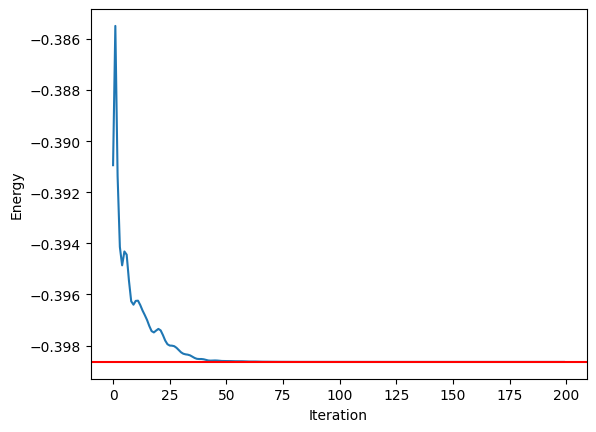

In [20]:
# plot the energy
import matplotlib.pyplot as plt
# detach the tensor and convert to numpy
energy_list = [x.detach().numpy() for x in energy_list]
plt.plot(energy_list)
# exact energy
plt.axhline(y=E_gs/N, color='r', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.show()